# 10FreqClasses

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np

## Training Set DIR

In [2]:
train_dataset_path='D:/DatasetMedicalWaste_10FreqClasses/DatasetMedicalWasteCropped/'

In [3]:
#train_dataset_path='D:/DatasetMedicalWasteCroppedBalanced/'

## Testing Set DIR

In [4]:
test_indoor_dataset_path='D:/DatasetMedicalWaste_10FreqClasses/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWaste_10FreqClasses/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWaste_10FreqClasses/DatasetMedicalWasteTestLabeledCropped/belt'

In [5]:
img_height=224
img_width=224
batch_size=64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1279 files belonging to 10 classes.
Using 1024 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['2WayFoleyCatheter', 'CottonBall', 'ExtensionTube', 'Glove', 'Mask', 'NGTube', 'Needle', 'OxygenMask', 'Syringe', 'UrineBag']
number of class = 10


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1279 files belonging to 10 classes.
Using 255 files for validation.


In [9]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 507 files belonging to 10 classes.


In [10]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1020 files belonging to 10 classes.


In [11]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 569 files belonging to 10 classes.


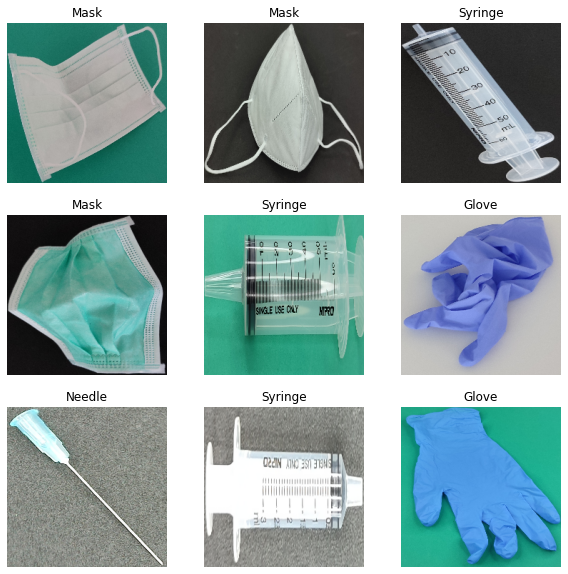

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Augmentation

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("vertical"),
  layers.RandomRotation(0.100),
  layers.RandomZoom(height_factor=0.025,width_factor=0.025),
  #layers.RandomContrast(0.300),
])

In [14]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64,)


In [17]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input,MobileNetV2

mobilenetv2_model = keras.applications.MobileNetV2(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

mobilenetv2_model_nooutput = mobilenetv2_model.layers[-2].output
custom_mobilenetv2_model = Model(inputs = mobilenetv2_model.input, outputs = mobilenetv2_model_nooutput)


## Freez Extractor+

In [18]:
custom_mobilenetv2_model.trainable = False
for layer in custom_mobilenetv2_model.layers:
    layer.trainable = False
## Freez
#custom_inceptionv3_model.layers[-1].trainable = True
#custom_inceptionv3_model.layers[-2].trainable = True
#custom_inceptionv3_model.layers[-3].trainable = True
print(custom_mobilenetv2_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [19]:
#tf.keras.utils.plot_model(custom_inceptionv3_model, to_file="InceptionRemoveOutput.png", show_shapes=True)

In [20]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_mobilenetv2_model)
# Classifier
#DeepDense
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', trainable=True))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10250     
Total params: 3,579,978
Trainable params: 1,321,994
Non-trainable params: 2,257,984
_________________________________________________________________


In [22]:
#class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

In [23]:
#model.layers[-1]._name = 'Classifier'
#model.layers[-2]._name = 'InceptionV3'
#print(len(model.layers))
#tf.keras.utils.plot_model(model, to_file="Incepv3_FreezExtractorOurOutputLayer.png", show_shapes=True)

# Fitting

In [1]:
path_to_model = 'D:/ModelMedicalWasteCheckpoint/10Freq_MobileNetV2/'

In [25]:
EPOCHS = 2000
save_model_interval = 200
checkpoint_filepath = path_to_model+'OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch{epoch:04d}.pb' # -val_acc{val_accuracy:.2f}
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr])

Epoch 1/2000
16/16 [==============================] - 17s 269ms/step - loss: 0.6754 - accuracy: 0.8086 - val_loss: 0.1006 - val_accuracy: 0.9725
Epoch 2/2000
16/16 [==============================] - 1s 75ms/step - loss: 0.0429 - accuracy: 0.9863 - val_loss: 0.0785 - val_accuracy: 0.9686
Epoch 3/2000
16/16 [==============================] - 1s 74ms/step - loss: 0.0195 - accuracy: 0.9961 - val_loss: 0.0615 - val_accuracy: 0.9843
Epoch 4/2000
16/16 [==============================] - 1s 75ms/step - loss: 0.0070 - accuracy: 0.9990 - val_loss: 0.0487 - val_accuracy: 0.9843
Epoch 5/2000
16/16 [==============================] - 1s 74ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9922
Epoch 6/2000
16/16 [==============================] - 1s 74ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0411 - val_accuracy: 0.9765
Epoch 7/2000
16/16 [==============================] - 1s 74ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0349 - val_accuracy: 0.98

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 201/2000
16/16 [==============================] - 1s 75ms/step - loss: 1.1354e-04 - accuracy: 1.0000 - val_loss: 0.0238 - val_accuracy: 0.9922
Epoch 202/2000
16/16 [==============================] - 1s 74ms/step - loss: 1.1543e-04 - accuracy: 1.0000 - val_loss: 0.0238 - val_accuracy: 0.9922
Epoch 203/2000
16/16 [==============================] - 1s 74ms/step - loss: 1.0300e-04 - accuracy: 1.0000 - val_loss: 0.0238 - val_accuracy: 0.9922
Epoch 204/2000
16/16 [==============================] - 1s 74ms/step - loss: 1.1267e-04 - accuracy: 1.0000 - val_loss: 0.0238 - val_accuracy: 0.9922
Epoch 205/2000
16/16 [==============================] - 1s 75ms/step - loss: 1.1820e-04 - accuracy: 1.0000 - val_loss: 0.0237 - val_accuracy: 0.9922
Epoch 206/2000
16/16 [==============================] - 1s 74ms/step - loss: 1.0611e-04 - accuracy: 1.0000 - val_loss: 0.0237 - val_accuracy: 0.9922
Epoch 207/2000
16/16 [==============================] - 1s 74ms/step - loss: 1.0717e-04 - accuracy: 1.0000

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 401/2000
16/16 [==============================] - 1s 76ms/step - loss: 7.4887e-05 - accuracy: 1.0000 - val_loss: 0.0225 - val_accuracy: 0.9922
Epoch 402/2000
16/16 [==============================] - 1s 76ms/step - loss: 6.6109e-05 - accuracy: 1.0000 - val_loss: 0.0228 - val_accuracy: 0.9922
Epoch 403/2000
16/16 [==============================] - 1s 75ms/step - loss: 6.7062e-05 - accuracy: 1.0000 - val_loss: 0.0228 - val_accuracy: 0.9922
Epoch 404/2000
16/16 [==============================] - 1s 75ms/step - loss: 5.8981e-05 - accuracy: 1.0000 - val_loss: 0.0227 - val_accuracy: 0.9922
Epoch 405/2000
16/16 [==============================] - 1s 75ms/step - loss: 6.2265e-05 - accuracy: 1.0000 - val_loss: 0.0227 - val_accuracy: 0.9922
Epoch 406/2000
16/16 [==============================] - 1s 75ms/step - loss: 6.3780e-05 - accuracy: 1.0000 - val_loss: 0.0226 - val_accuracy: 0.9922
Epoch 407/2000
16/16 [==============================] - 1s 75ms/step - loss: 5.9918e-05 - accuracy: 1.0000

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 601/2000
16/16 [==============================] - 1s 75ms/step - loss: 2.6967e-05 - accuracy: 1.0000 - val_loss: 0.0216 - val_accuracy: 0.9922
Epoch 602/2000
16/16 [==============================] - 1s 75ms/step - loss: 2.5461e-05 - accuracy: 1.0000 - val_loss: 0.0216 - val_accuracy: 0.9922
Epoch 603/2000
16/16 [==============================] - 1s 75ms/step - loss: 2.4503e-05 - accuracy: 1.0000 - val_loss: 0.0212 - val_accuracy: 0.9922
Epoch 604/2000
16/16 [==============================] - 1s 75ms/step - loss: 1.8029e-05 - accuracy: 1.0000 - val_loss: 0.0212 - val_accuracy: 0.9922
Epoch 605/2000
16/16 [==============================] - 1s 75ms/step - loss: 2.1136e-05 - accuracy: 1.0000 - val_loss: 0.0213 - val_accuracy: 0.9922
Epoch 606/2000
16/16 [==============================] - 1s 75ms/step - loss: 2.3614e-05 - accuracy: 1.0000 - val_loss: 0.0217 - val_accuracy: 0.9922
Epoch 607/2000
16/16 [==============================] - 1s 75ms/step - loss: 2.3767e-05 - accuracy: 1.0000

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 801/2000
16/16 [==============================] - 1s 75ms/step - loss: 1.0057e-05 - accuracy: 1.0000 - val_loss: 0.0212 - val_accuracy: 0.9922
Epoch 802/2000
16/16 [==============================] - 1s 75ms/step - loss: 5.7222e-06 - accuracy: 1.0000 - val_loss: 0.0210 - val_accuracy: 0.9922
Epoch 803/2000
16/16 [==============================] - 1s 75ms/step - loss: 5.4388e-06 - accuracy: 1.0000 - val_loss: 0.0208 - val_accuracy: 0.9922
Epoch 804/2000
16/16 [==============================] - 1s 75ms/step - loss: 6.3227e-06 - accuracy: 1.0000 - val_loss: 0.0205 - val_accuracy: 0.9922
Epoch 805/2000
16/16 [==============================] - 1s 75ms/step - loss: 5.9707e-06 - accuracy: 1.0000 - val_loss: 0.0204 - val_accuracy: 0.9922
Epoch 806/2000
16/16 [==============================] - 1s 75ms/step - loss: 6.5659e-06 - accuracy: 1.0000 - val_loss: 0.0206 - val_accuracy: 0.9922
Epoch 807/2000
16/16 [==============================] - 1s 75ms/step - loss: 4.8743e-06 - accuracy: 1.0000

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1001/2000
16/16 [==============================] - 1s 75ms/step - loss: 1.2908e-06 - accuracy: 1.0000 - val_loss: 0.0195 - val_accuracy: 0.9922
Epoch 1002/2000
16/16 [==============================] - 1s 75ms/step - loss: 1.6618e-06 - accuracy: 1.0000 - val_loss: 0.0193 - val_accuracy: 0.9922
Epoch 1003/2000
16/16 [==============================] - 1s 75ms/step - loss: 1.4884e-06 - accuracy: 1.0000 - val_loss: 0.0192 - val_accuracy: 0.9922
Epoch 1004/2000
16/16 [==============================] - 1s 75ms/step - loss: 2.1613e-06 - accuracy: 1.0000 - val_loss: 0.0195 - val_accuracy: 0.9922
Epoch 1005/2000
16/16 [==============================] - 1s 75ms/step - loss: 1.8043e-06 - accuracy: 1.0000 - val_loss: 0.0198 - val_accuracy: 0.9922
Epoch 1006/2000
16/16 [==============================] - 1s 75ms/step - loss: 1.7489e-06 - accuracy: 1.0000 - val_loss: 0.0198 - val_accuracy: 0.9922
Epoch 1007/2000
16/16 [==============================] - 1s 75ms/step - loss: 1.6378e-06 - accuracy:

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1201/2000
16/16 [==============================] - 1s 75ms/step - loss: 6.2119e-07 - accuracy: 1.0000 - val_loss: 0.0203 - val_accuracy: 0.9922
Epoch 1202/2000
16/16 [==============================] - 1s 75ms/step - loss: 5.0303e-07 - accuracy: 1.0000 - val_loss: 0.0204 - val_accuracy: 0.9922
Epoch 1203/2000
16/16 [==============================] - 1s 75ms/step - loss: 5.7334e-07 - accuracy: 1.0000 - val_loss: 0.0203 - val_accuracy: 0.9922
Epoch 1204/2000
16/16 [==============================] - 1s 75ms/step - loss: 4.6030e-07 - accuracy: 1.0000 - val_loss: 0.0205 - val_accuracy: 0.9922
Epoch 1205/2000
16/16 [==============================] - 1s 80ms/step - loss: 6.8230e-07 - accuracy: 1.0000 - val_loss: 0.0206 - val_accuracy: 0.9922
Epoch 1206/2000
16/16 [==============================] - 1s 76ms/step - loss: 5.7358e-07 - accuracy: 1.0000 - val_loss: 0.0205 - val_accuracy: 0.9922
Epoch 1207/2000
16/16 [==============================] - 1s 80ms/step - loss: 5.5541e-07 - accuracy:

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1401/2000
16/16 [==============================] - 1s 74ms/step - loss: 2.7718e-07 - accuracy: 1.0000 - val_loss: 0.0198 - val_accuracy: 0.9922
Epoch 1402/2000
16/16 [==============================] - 1s 74ms/step - loss: 2.4890e-07 - accuracy: 1.0000 - val_loss: 0.0198 - val_accuracy: 0.9922
Epoch 1403/2000
16/16 [==============================] - 1s 74ms/step - loss: 2.3760e-07 - accuracy: 1.0000 - val_loss: 0.0200 - val_accuracy: 0.9922
Epoch 1404/2000
16/16 [==============================] - 1s 74ms/step - loss: 2.6112e-07 - accuracy: 1.0000 - val_loss: 0.0199 - val_accuracy: 0.9922
Epoch 1405/2000
16/16 [==============================] - 1s 74ms/step - loss: 2.5530e-07 - accuracy: 1.0000 - val_loss: 0.0200 - val_accuracy: 0.9922
Epoch 1406/2000
16/16 [==============================] - 1s 74ms/step - loss: 2.4401e-07 - accuracy: 1.0000 - val_loss: 0.0200 - val_accuracy: 0.9922
Epoch 1407/2000
16/16 [==============================] - 1s 74ms/step - loss: 3.4540e-07 - accuracy:

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1601/2000
16/16 [==============================] - 1s 75ms/step - loss: 1.2107e-07 - accuracy: 1.0000 - val_loss: 0.0201 - val_accuracy: 0.9922
Epoch 1602/2000
16/16 [==============================] - 1s 75ms/step - loss: 1.6019e-07 - accuracy: 1.0000 - val_loss: 0.0202 - val_accuracy: 0.9922
Epoch 1603/2000
16/16 [==============================] - 1s 75ms/step - loss: 1.7125e-07 - accuracy: 1.0000 - val_loss: 0.0203 - val_accuracy: 0.9922
Epoch 1604/2000
16/16 [==============================] - 1s 75ms/step - loss: 1.2736e-07 - accuracy: 1.0000 - val_loss: 0.0202 - val_accuracy: 0.9922
Epoch 1605/2000
16/16 [==============================] - 1s 75ms/step - loss: 1.9232e-07 - accuracy: 1.0000 - val_loss: 0.0201 - val_accuracy: 0.9922
Epoch 1606/2000
16/16 [==============================] - 1s 75ms/step - loss: 1.3213e-07 - accuracy: 1.0000 - val_loss: 0.0201 - val_accuracy: 0.9922
Epoch 1607/2000
16/16 [==============================] - 1s 75ms/step - loss: 2.3830e-07 - accuracy:

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1801/2000
16/16 [==============================] - 1s 74ms/step - loss: 1.0338e-07 - accuracy: 1.0000 - val_loss: 0.0208 - val_accuracy: 0.9922
Epoch 1802/2000
16/16 [==============================] - 1s 74ms/step - loss: 1.1292e-07 - accuracy: 1.0000 - val_loss: 0.0208 - val_accuracy: 0.9922
Epoch 1803/2000
16/16 [==============================] - 1s 74ms/step - loss: 1.0757e-07 - accuracy: 1.0000 - val_loss: 0.0208 - val_accuracy: 0.9922
Epoch 1804/2000
16/16 [==============================] - 1s 74ms/step - loss: 9.4995e-08 - accuracy: 1.0000 - val_loss: 0.0207 - val_accuracy: 0.9922
Epoch 1805/2000
16/16 [==============================] - 1s 74ms/step - loss: 6.9267e-08 - accuracy: 1.0000 - val_loss: 0.0207 - val_accuracy: 0.9922
Epoch 1806/2000
16/16 [==============================] - 1s 74ms/step - loss: 1.0198e-07 - accuracy: 1.0000 - val_loss: 0.0206 - val_accuracy: 0.9922
Epoch 1807/2000
16/16 [==============================] - 1s 74ms/step - loss: 9.0920e-08 - accuracy:

c:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Text(0.5, 1.0, 'Training and Validation Accuracy')

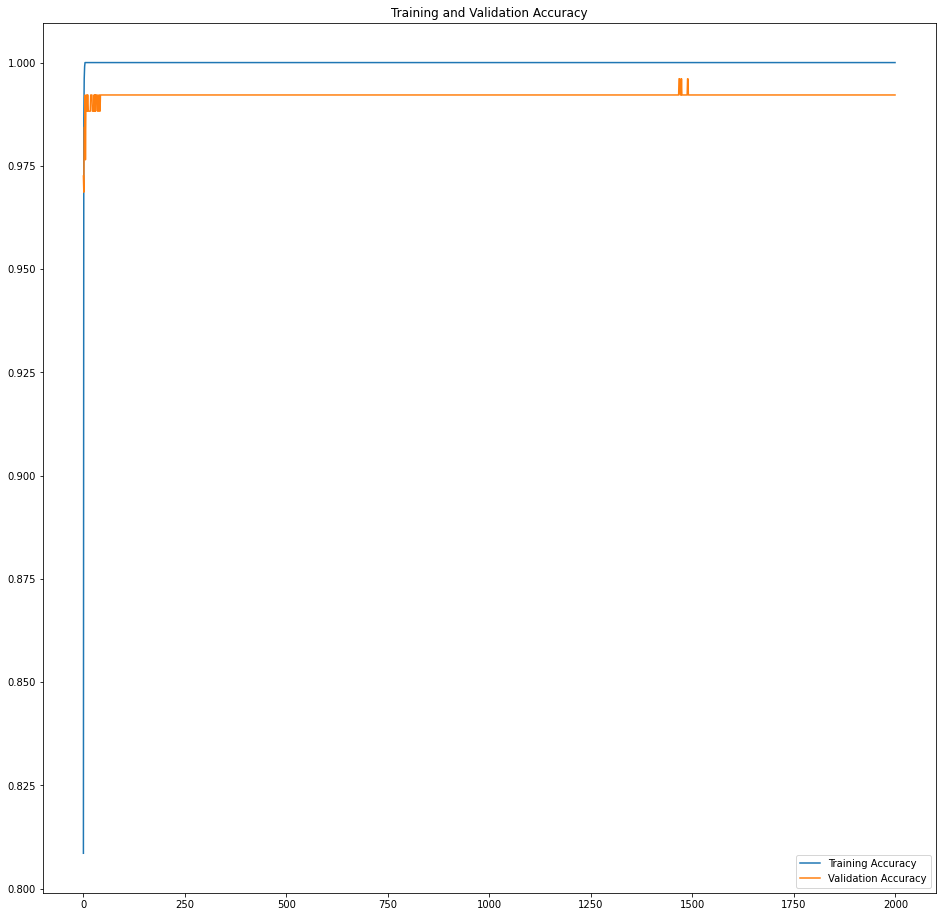

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


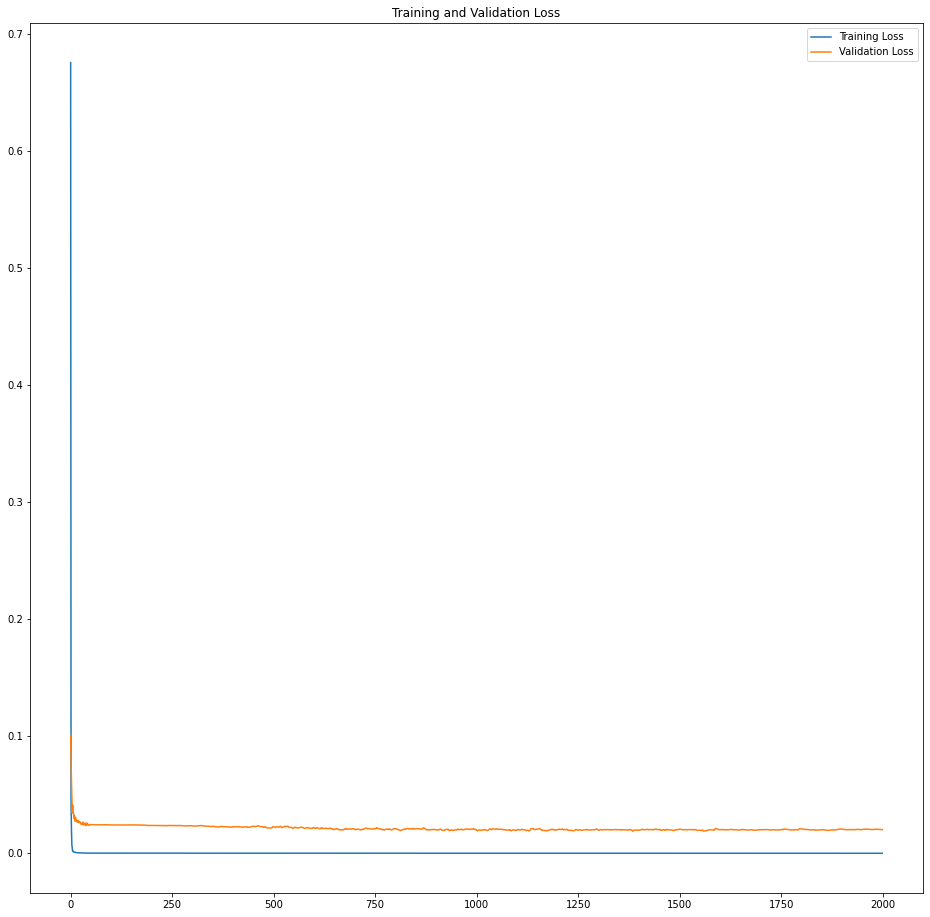

In [27]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

8/8 [==============================] - 4s 117ms/step - loss: 0.3500 - accuracy: 0.9250
test_indoor_ds_results:test loss, test acc: [0.3499666452407837, 0.9250493049621582]


In [29]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

16/16 [==============================] - 9s 275ms/step - loss: 0.9283 - accuracy: 0.8667
test_outdoor_ds_results:test loss, test acc: [0.9282994866371155, 0.8666666746139526]


In [30]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

9/9 [==============================] - 2s 109ms/step - loss: 0.9619 - accuracy: 0.8682
test_belt_ds_results:test loss, test acc: [0.9618924856185913, 0.868189811706543]


In [31]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/10Freq_MobileNetV2/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0200.pb',
 'D:/ModelMedicalWasteCheckpoint/10Freq_MobileNetV2/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0400.pb',
 'D:/ModelMedicalWasteCheckpoint/10Freq_MobileNetV2/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0600.pb',
 'D:/ModelMedicalWasteCheckpoint/10Freq_MobileNetV2/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0800.pb',
 'D:/ModelMedicalWasteCheckpoint/10Freq_MobileNetV2/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch1000.pb',
 'D:/ModelMedicalWasteCheckpoint/10Freq_MobileNetV2/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch1200.pb',
 'D:/ModelMedicalWasteCheckpoint/10Freq_MobileNetV2/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch1400.pb',
 'D:/ModelMedicalWasteCheckpoint/10Freq_MobileNetV2/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch1600.pb',
 'D:/ModelMedicalWasteCheckpoint/10Freq_MobileNetV2/OurOutputLayer_DeepD

# Testing in testset

In [32]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

9/9 [==============================] - 1s 58ms/step - loss: 0.6528 - accuracy: 0.8524
Epoch200 
 test_indoor_acc=0.9171597361564636 
 test_outdoor_acc=0.8568627238273621 
 test_belt_acc=0.8523725867271423
9/9 [==============================] - 1s 58ms/step - loss: 0.6813 - accuracy: 0.8506
Epoch400 
 test_indoor_acc=0.9171597361564636 
 test_outdoor_acc=0.8568627238273621 
 test_belt_acc=0.8506151437759399
9/9 [==============================] - 1s 58ms/step - loss: 0.7075 - accuracy: 0.8559
Epoch600 
 test_indoor_acc=0.9230769276618958 
 test_outdoor_acc=0.8558823466300964 
 test_belt_acc=0.8558875322341919
9/9 [==============================] - 1s 58ms/step - loss: 0.7573 - accuracy: 0.8612
Epoch800 
 test_indoor_acc=0.9230769276618958 
 test_outdoor_acc=0.8568627238273621 
 test_belt_acc=0.8611599206924438
9/9 [==============================] - 1s 58ms/step - loss: 0.8256 - accuracy: 0.8629
Epoch1000 
 test_indoor_acc=0.9230769276618958 
 test_outdoor_acc=0.8598039150238037 
 test_be

In [33]:
#Average
test_avg_acc = []
for i in range(len(test_indoor_acc)):
    tmp_avg = (test_indoor_acc[i] + test_outdoor_acc[i] + test_belt_acc[i]) / 3.0
    test_avg_acc.append(tmp_avg)
    

range(200, 2200, 200)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

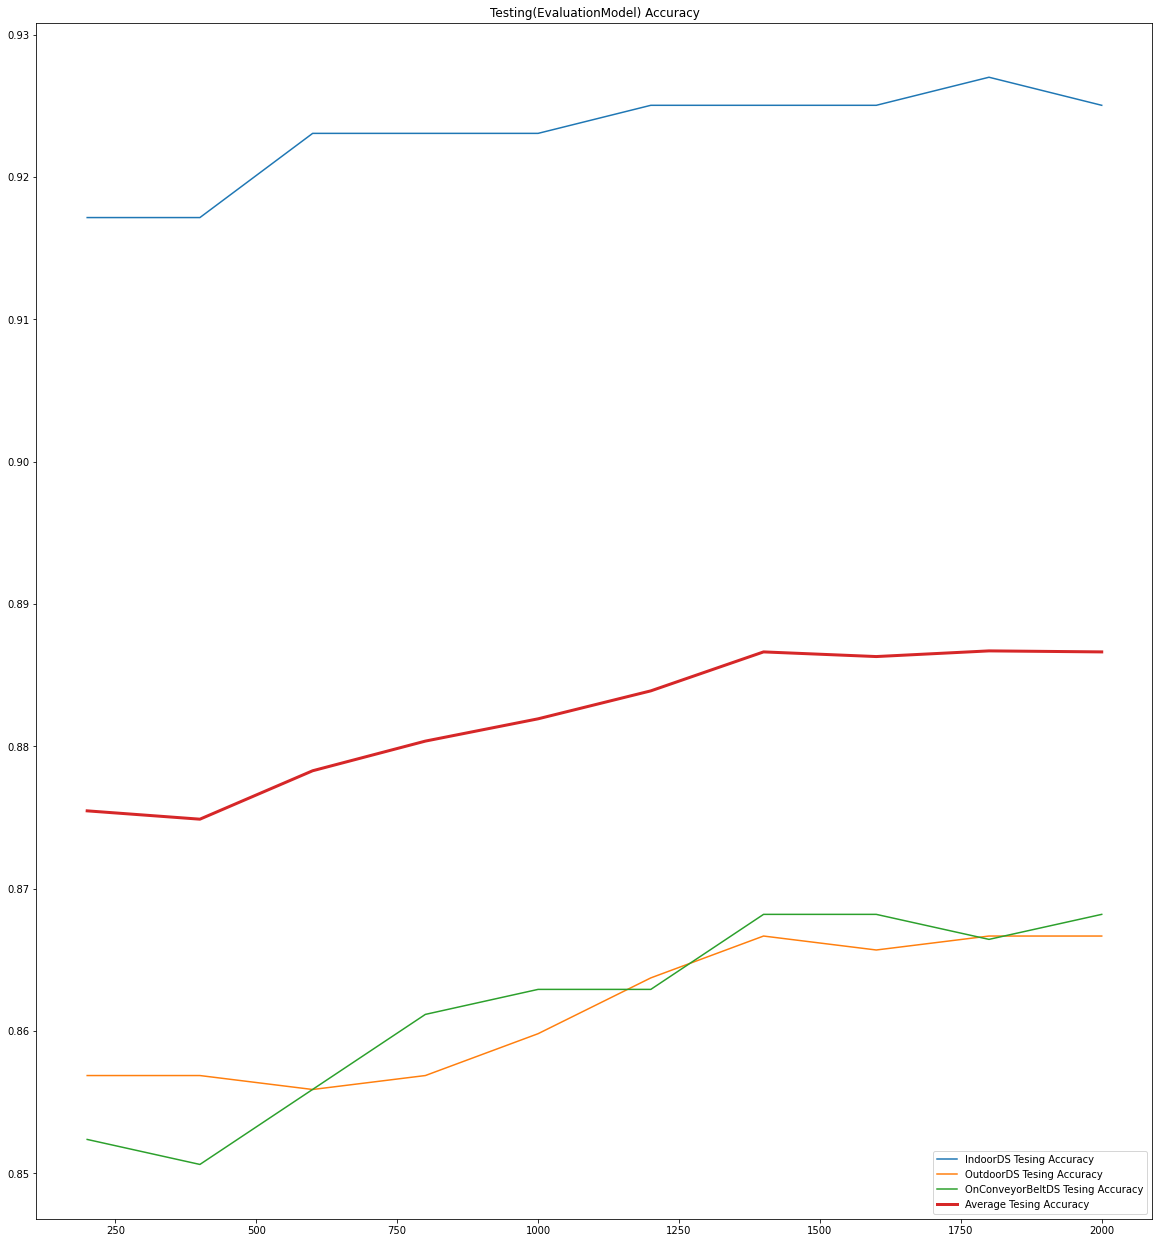

In [34]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.plot(epochs_range, test_avg_acc, label='Average Tesing Accuracy',linewidth=3)
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

### Max acc

In [35]:
#Find Max Index and Value
print(f"max acc -> {max(test_avg_acc)}")
max_index = test_avg_acc.index(max(test_avg_acc))
print(f"max index -> {max_index}")
print(f"The [Epoch] of max acc -> {(max_index+1)*save_model_interval}")

max acc -> 0.8867068886756897
max index -> 8
The [Epoch] of max acc -> 1800


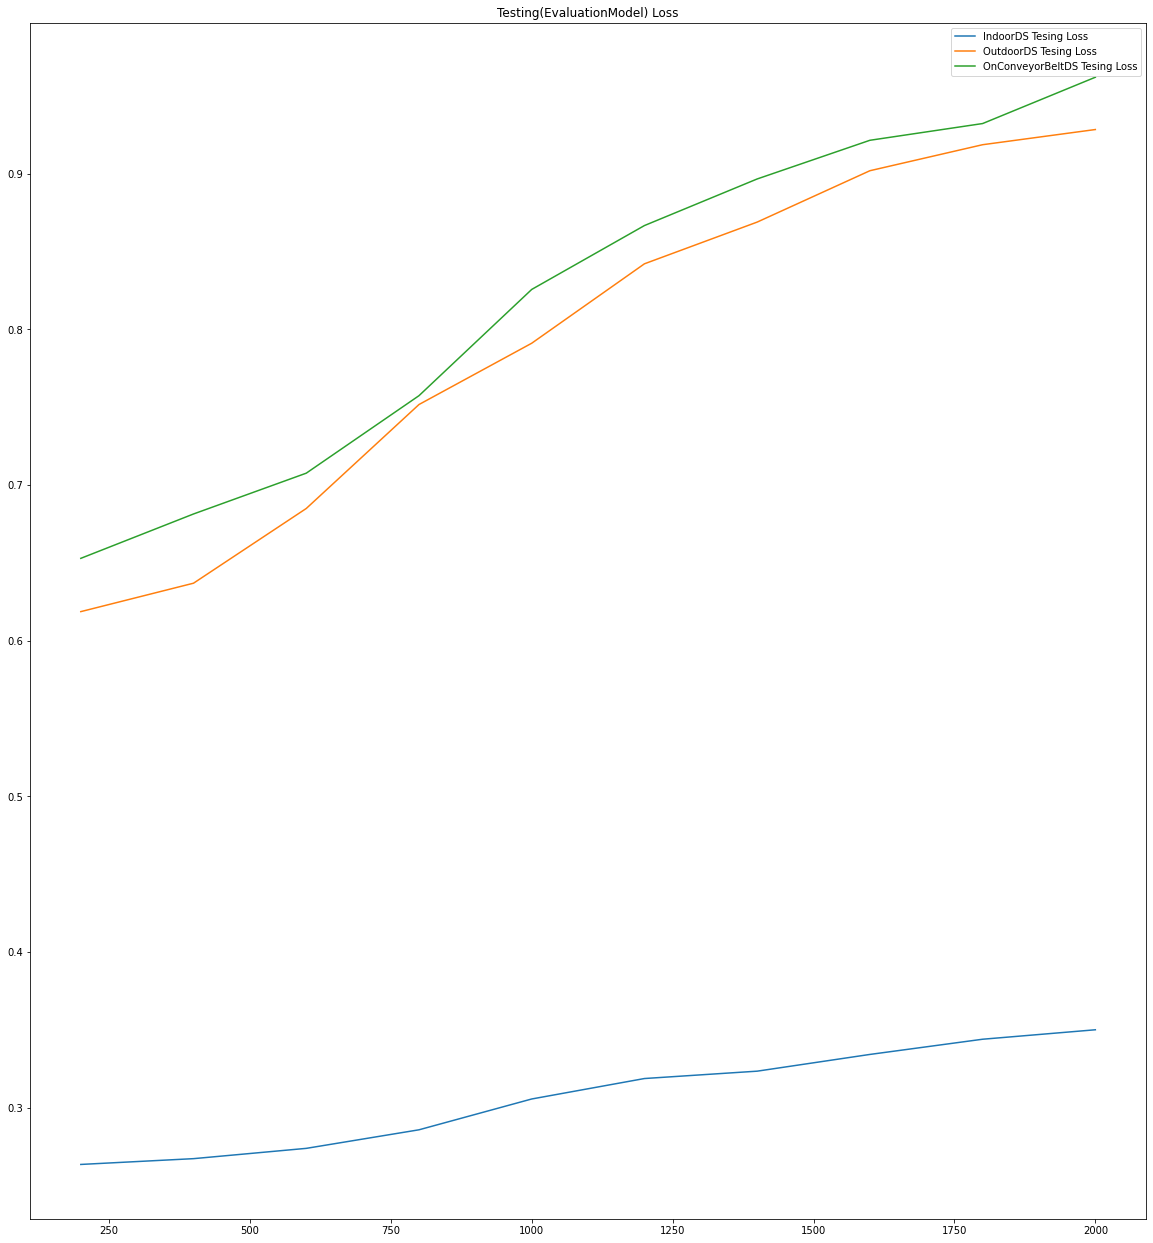

In [36]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [37]:
test_indoor_acc

[0.9171597361564636,
 0.9171597361564636,
 0.9230769276618958,
 0.9230769276618958,
 0.9230769276618958,
 0.9250493049621582,
 0.9250493049621582,
 0.9250493049621582,
 0.9270216822624207,
 0.9250493049621582]

In [38]:
test_outdoor_acc

[0.8568627238273621,
 0.8568627238273621,
 0.8558823466300964,
 0.8568627238273621,
 0.8598039150238037,
 0.863725483417511,
 0.8666666746139526,
 0.865686297416687,
 0.8666666746139526,
 0.8666666746139526]

In [39]:
test_belt_acc

[0.8523725867271423,
 0.8506151437759399,
 0.8558875322341919,
 0.8611599206924438,
 0.862917423248291,
 0.862917423248291,
 0.868189811706543,
 0.868189811706543,
 0.8664323091506958,
 0.868189811706543]

In [40]:
test_indoor_loss

[0.26345381140708923,
 0.2671715319156647,
 0.27378174662590027,
 0.2857081890106201,
 0.3055025339126587,
 0.31864386796951294,
 0.32337477803230286,
 0.3341226279735565,
 0.3438914716243744,
 0.3499666452407837]

In [41]:
test_outdoor_loss

[0.6185932755470276,
 0.6368581652641296,
 0.684849739074707,
 0.7516382932662964,
 0.7910168170928955,
 0.8420416712760925,
 0.8688398003578186,
 0.9018377065658569,
 0.918547511100769,
 0.9282994866371155]

In [42]:
test_belt_loss

[0.6528218388557434,
 0.6813281774520874,
 0.7075376510620117,
 0.7573204040527344,
 0.8255720138549805,
 0.8666110038757324,
 0.8965429663658142,
 0.9213896989822388,
 0.9321441650390625,
 0.9618924856185913]

## Load Last Epoch and test in each class

In [57]:
# Del dataset memory and reload
# RAM
del train_ds
del val_ds
del test_indoor_ds
del test_outdoor_ds
del test_belt_ds
# VRAM
#from numba import cuda
#cuda.select_device(0)
#cuda.close()

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.mobilenet_v2 import preprocess_input

last_epoch_model = tf.keras.models.load_model(path_to_model+'OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch2000.pb')

test_indoor_dataset_path='D:/DatasetMedicalWaste_10FreqClasses/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWaste_10FreqClasses/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWaste_10FreqClasses/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=224
img_width=224
batch_size=64

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['2WayFoleyCatheter', 'CottonBall', 'ExtensionTube', 'Glove', 'Mask', 'NGTube', 'Needle', 'OxygenMask', 'Syringe', 'UrineBag']

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)}")
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)}")
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)}")
x_all = np.concatenate([x_test_indoor,x_test_outdoor,x_test_belt],axis=0)
y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
y_all_predicted = last_epoch_model.predict(x_all,batch_size=128)
del x_test_indoor,x_test_outdoor,x_test_belt
del x_all

Found 507 files belonging to 10 classes.
Found 1020 files belonging to 10 classes.
Found 569 files belonging to 10 classes.
train_indoor num x,y : 507,507
train_outdoor num x,y : 1020,1020
train_belt num x,y : 569,569
all num x,y :2096,2096


In [3]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=2096
TP=1847
FP=249
acc=0.8812022900763359
all check = 2096


### acc

In [4]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


2WayFoleyCatheter acc = 70.1492537313433%
CottonBall acc = 98.80239520958084%
ExtensionTube acc = 55.28455284552846%
Glove acc = 97.91666666666666%
Mask acc = 98.7012987012987%
NGTube acc = 56.774193548387096%
Needle acc = 95.71428571428572%
OxygenMask acc = 95.48872180451127%
Syringe acc = 98.47908745247148%
UrineBag acc = 57.49999999999999%



all_avg_eachclass = 82.48104556740734%


In [5]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[ 94,   1,  10,   2,   6,   5,  11,   0,   3,   2],
       [  0, 165,   0,   2,   0,   0,   0,   0,   0,   0],
       [  0,   0,  68,   0,  16,  29,   9,   1,   0,   0],
       [  2,   0,   0, 329,   2,   0,   0,   3,   0,   0],
       [  0,   0,   0,   3, 380,   0,   0,   2,   0,   0],
       [  1,   0,   3,   8,  23,  88,  20,   4,   6,   2],
       [  0,   0,   0,   1,   0,   7, 268,   0,   4,   0],
       [  0,   0,   0,   1,   0,   1,   4, 127,   0,   0],
       [  0,   0,   0,   0,   0,   0,   4,   0, 259,   0],
       [  0,   0,   0,   6,  15,   0,   0,  21,   9,  69]], dtype=int64)

In [6]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[70.14925373,  0.74626866,  7.46268657,  1.49253731,  4.47761194,
         3.73134328,  8.20895522,  0.        ,  2.23880597,  1.49253731],
       [ 0.        , 98.80239521,  0.        ,  1.19760479,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , 55.28455285,  0.        , 13.00813008,
        23.57723577,  7.31707317,  0.81300813,  0.        ,  0.        ],
       [ 0.5952381 ,  0.        ,  0.        , 97.91666667,  0.5952381 ,
         0.        ,  0.        ,  0.89285714,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.77922078, 98.7012987 ,
         0.        ,  0.        ,  0.51948052,  0.        ,  0.        ],
       [ 0.64516129,  0.        ,  1.93548387,  5.16129032, 14.83870968,
        56.77419355, 12.90322581,  2.58064516,  3.87096774,  1.29032258],
       [ 0.        ,  0.        ,  0.        ,  0.35714286,  0.        ,
         2.5       , 95.71428571,  0.        

<AxesSubplot:>

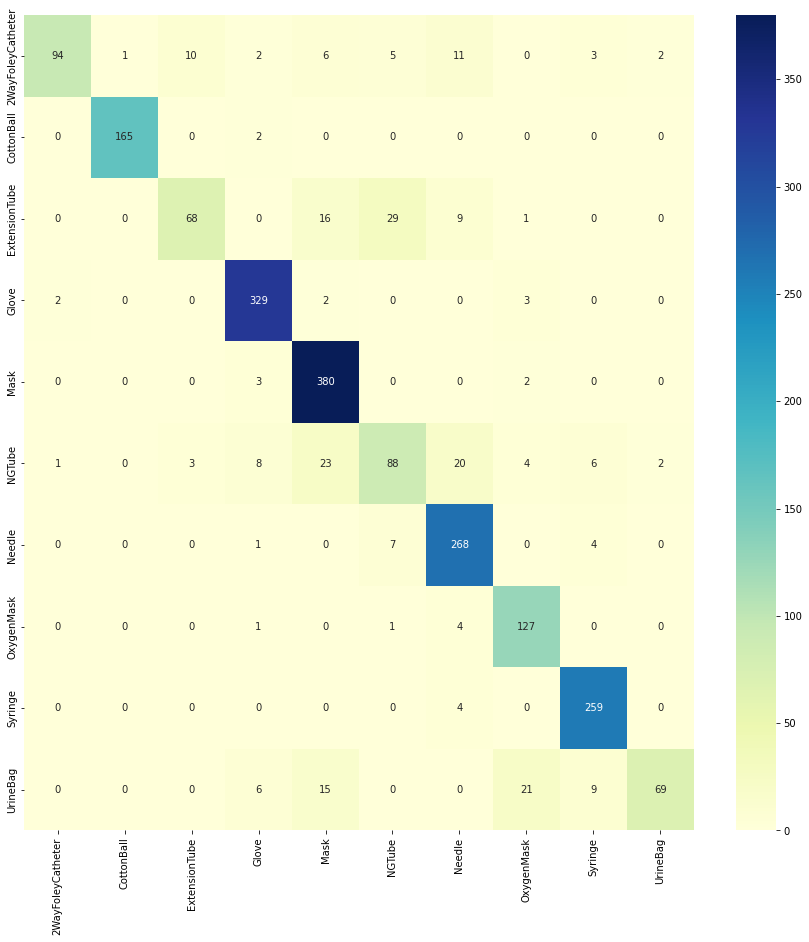

In [7]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (15,15))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt="d")

<AxesSubplot:>

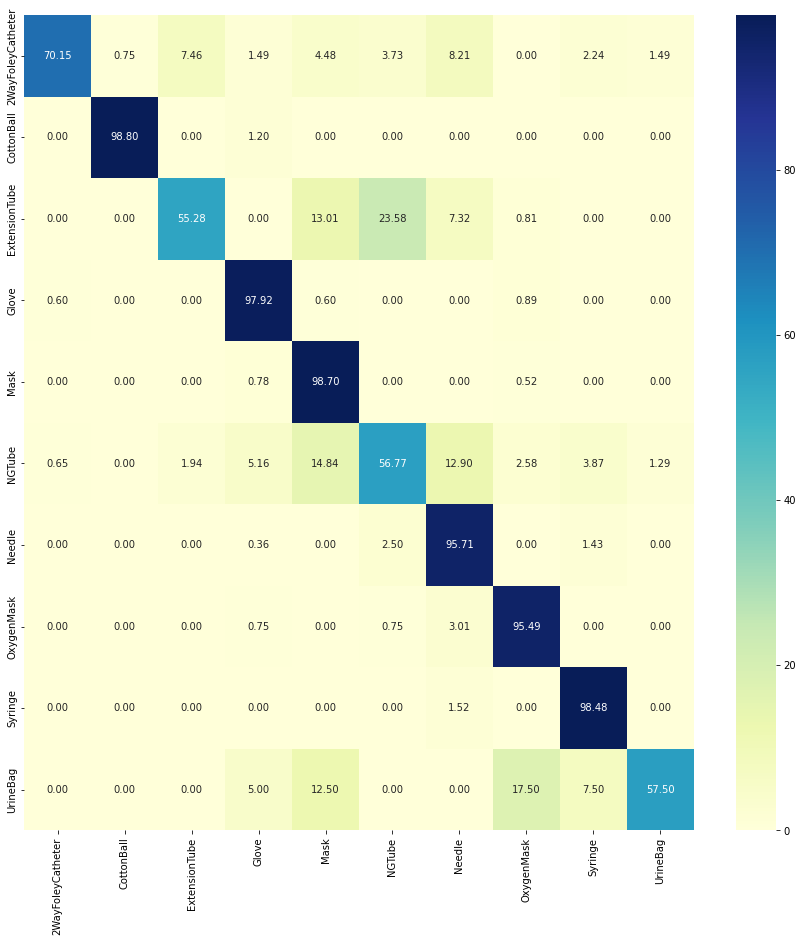

In [8]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (15,15))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt=".2f")